In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pygsp
import mplleaflet

In [2]:
from utils.indexes import days_index, hour_rides, transform_source


March 1st: first reported case in New York 
<br>
March 4th: Yeshiva University campus closed, high school in the Bronx 
<br>
March 9th 16 confirmed cases 
<br>
March 10th: mitigation measures expanded (online classes for universities) 
<br>
March 11th: CUNY and SUNY closed
<br>
March 14th: first reported death in New York 
<br>
March 16th: NYC public schools closed 
<br>
March 20th: stay-at-home order for non-essential workers, total over 7000 cases
<br>
March 22nd: shortages of PPE for health workers, recommendation that health facilities stop testing non-hospitalized patients
<br>
March 26th: USNS Comfort heading to NYC to assist local hospitals 


New York Weather : MARCH

[weather data](https://www.timeanddate.com/weather/usa/new-york/historic?month=3&year=2020)

In [3]:
df = pd.read_csv('./data/202003-citibike-tripdata.csv')
n_start_station = len(df['start station id'].unique())
n_end_station = len(df['end station id'].unique())


In [4]:
total_station_id = set(df['start station id']).union(set(df['end station id']))
n_tot_station = len(total_station_id)

In [5]:
id_index = dict(zip(sorted(total_station_id), np.arange(n_tot_station)))

In [6]:
df.head()

tripduration                 starttime                  stoptime  \
0          1589  2020-03-01 00:00:03.6400  2020-03-01 00:26:32.9860   
1           389  2020-03-01 00:00:16.7560  2020-03-01 00:06:46.0620   
2           614  2020-03-01 00:00:20.0580  2020-03-01 00:10:34.2200   
3           597  2020-03-01 00:00:24.3510  2020-03-01 00:10:22.3390   
4          1920  2020-03-01 00:00:26.1120  2020-03-01 00:32:26.2680   

   start station id        start station name  start station latitude  \
0               224     Spruce St & Nassau St               40.711464   
1               293     Lafayette St & E 8 St               40.730207   
2               379           W 31 St & 7 Ave               40.749156   
3              3739  Perry St & Greenwich Ave               40.735918   
4               236       St Marks Pl & 2 Ave               40.728419   

   start station longitude  end station id             end station name  \
0               -74.005524            3574  Prospect Pl & Underhill Ave   
1               -73.991026             223              W 13 St & 7 Ave   
2               -73.991600             515             W 43 St & 10 Ave   
3               -74.000939             325              E 19 St & 3 Ave   
4               -73.987140            3124                46 Ave & 5 St   

   end station latitude  end station longitude  bikeid    usertype  \
0             40.676969             -73.965790   16214  Subscriber   
1             40.737815             -73.999947   29994  Subscriber   
2             40.760094             -73.994618   39853  Subscriber   
3             40.736245             -73.984738   42608  Subscriber   
4             40.747310             -73.954510   36288  Subscriber   

   birth year  gender  
0        1980       1  
1        1991       2  
2        1991       1  
3        1989       1  
4        1993       1

# Find Locations #

In [7]:
locations = dict()
for e in id_index.keys():
    if df[df['start station id'] == e]['start station latitude'].shape[0]:
        locations[id_index[e]] = (df[df['start station id'] == e]['start station longitude'].iloc[0],
                                  df[df['start station id'] == e]['start station latitude'].iloc[0])
    else:
        locations[id_index[e]] = (df[df['end station id'] == e]['end station longitude'].iloc[0],
                                  df[df['end station id'] == e]['end station latitude'].iloc[0])
 

# MARCH #

In [8]:
# Dictionary with days starting indexes
"""d = days_index(df)
with open('./data/variables/march_index.pickle', 'wb') as file:
    pickle.dump(d, file)"""


"d = days_index(df)\nwith open('./data/variables/march_index.pickle', 'wb') as file:\n    pickle.dump(d, file)"

In [9]:
# Load day indexes for March
with open('./data/python_variables/march_index.pickle', 'rb') as file:
    d = pickle.load(file)

In [10]:
d_a = [e for e in d.values()]
d_a.append(df.shape[0])
d_a = np.array(d_a)
rides_day = d_a[1:] - d_a[:-1]

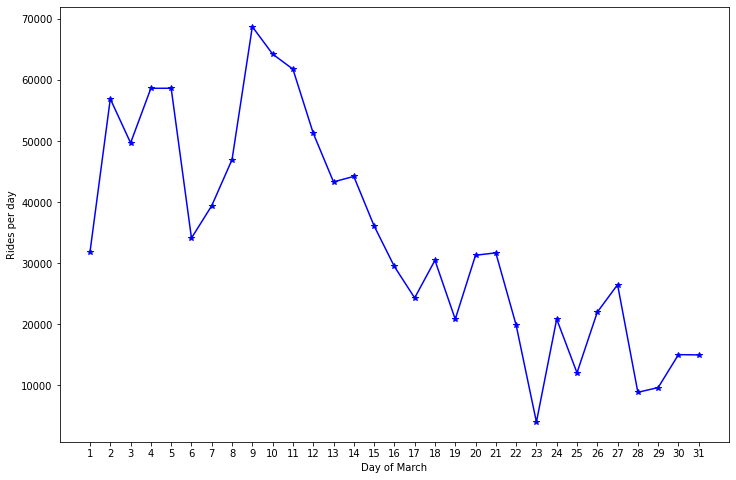

In [11]:
# Rides Per Day
plt.figure(figsize=(12,8))
_ = plt.plot(np.arange(1, 32), rides_day, color='blue', marker='*')
_ = plt.xticks(np.arange(1, 32), np.arange(1, 32))
_ = plt.xlabel("Day of March")
_ = plt.ylabel("Rides per day")
plt.grid(False)
plt.savefig('./plots/rides_per_day.eps')

In [12]:
print("Maximum number of rides on day {}".format(np.argmax(rides_day)))
print("With {} rides".format(np.max(rides_day)))

Maximum number of rides on day 8
With 68768 rides


In [13]:
# Paramters 
ths = 3

## 2st-8th of March ##

In [650]:
# 2 -> Monday
# Choose day 
days = [2, 3, 4, 5, 6]
#days = [4]

# Find all connections with weights
adj_2_6_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_2_6_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_2_6_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    

Day 2 loaded...
Day 3 loaded...
Day 4 loaded...
Day 5 loaded...
Day 6 loaded...


In [651]:
print("Total number of rides : {}".format(np.sum(adj_2_6_tot) / 2))

Total number of rides : 258160.0


In [652]:
adj_2_6 = adj_2_6_tot.copy()
adj_2_6[adj_2_6 < ths] = 0
adj_2_6[adj_2_6 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_2_6) / 2))

for i in range(n_tot_station):
    adj_2_6[i, i] = 0

Unweighted number of rides (edges) : 59188.0


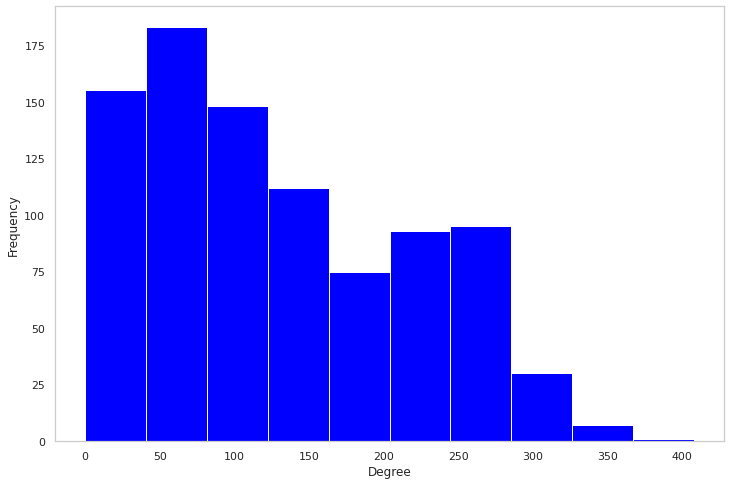

In [653]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_2_6 = nx.from_numpy_matrix(adj_2_6)
g_2_6_tot = nx.from_numpy_matrix(adj_2_6)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_2_6 = np.array([x[1] for x in g_2_6.degree])
_ = plt.hist(degs_2_6, color='blue')
plt.savefig('./plots/degree_2_8.eps')

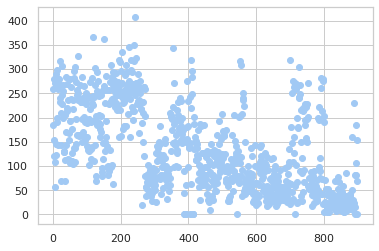

In [654]:
plt.scatter(np.arange(n_tot_station), degs_2_6)

## Plot ##

### Clustering ###

In [655]:
isolated_nodes_2_6 = []
for e in nx.connected_components(g_2_6):
    if len(e) < 3:
        isolated_nodes_2_6.append(e.pop())

g_2_6.remove_nodes_from(isolated_nodes_2_6)

for e in nx.connected_components(g_2_6):
    if len(e) < 3:
        print(e)

In [656]:
G_2_6 = pygsp.graphs.Graph(nx.adjacency_matrix(g_2_6))

G_2_6.compute_laplacian()
G_2_6.compute_fourier_basis()

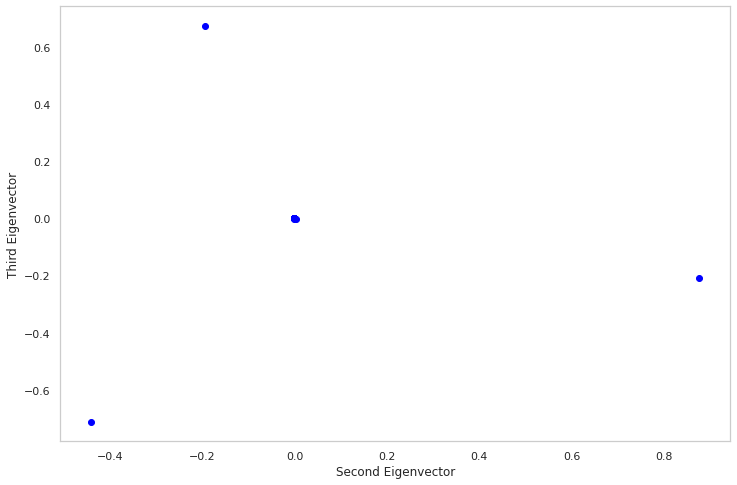

In [657]:

# Rides Per Day
plt.figure(figsize=(12,8))
plt.scatter(G_2_6.U[:,1], G_2_6.U[:,2], color='blue')
_ = plt.xlabel("Second Eigenvector")
_ = plt.ylabel("Third Eigenvector")
plt.grid(False)
plt.savefig('./plots/spectral_2_8.eps')

In [23]:
nx.write_gexf(g_2_6, "./graphs/g_2_6.gexf")

In [678]:
point = np.array([G_2_6.U[:,1], G_2_6.U[:,2], G_2_6.U[:,2]]).T

In [679]:
km = KMeans(n_clusters=4, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(points)

In [681]:
nx.algorithms.cluster.average_clustering(g_2_6)

0.4433088952321857

In [659]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from networkx.algorithms.community.quality import performance
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.asyn_fluid import asyn_fluidc

In [719]:
ks = [4,5,6]
metrics = {}
for k in ks:
    metrics[k] = []
    perf = []
    cov  = []
    for i in range(10):
        c_g = list(asyn_fluidc(g_2_6, k))
        perf.append(performance(g_2_6, c_g))
        cov.append(coverage(g_2_6, c_g))
    metrics[k].append(np.array(perf))
    metrics[k].append(np.array(cov))
    
    print("\n")
    
    print("Average Performance with {} clusters : {}".format(k, np.mean(np.array(perf))))
    print("Std on Performance with {} clusters : {}".format(k, np.std(np.array(perf))))
    print("Average Coverage with {} clusters: {}".format(k, np.mean(np.array(cov))))
    print("Std on Coverage with {} clusters: {}".format(k, np.std(np.array(cov))))


Average Performance with 4 clusters : 0.787654161473059
Std on Performance with 4 clusters : 0.016675832637183308
Average Coverage with 4 clusters: 0.803410365335599
Std on Coverage with 4 clusters: 0.040048199972280554
Average Performance with 5 clusters : 0.836816090556248
Std on Performance with 5 clusters : 0.005975216616064147
Average Coverage with 5 clusters: 0.7161155480033984
Std on Coverage with 5 clusters: 0.026204124377494097
Average Performance with 6 clusters : 0.8472648689184122
Std on Performance with 6 clusters : 0.017577835291267874
Average Coverage with 6 clusters: 0.6856737468139337
Std on Coverage with 6 clusters: 0.05450075292924755


In [715]:
cols = {}
for i in range(len(c_g)):
    for node in c_g[i]:
        cols[node] = i

l_c = [cols[e] for e in sorted(list(cols.keys()))]

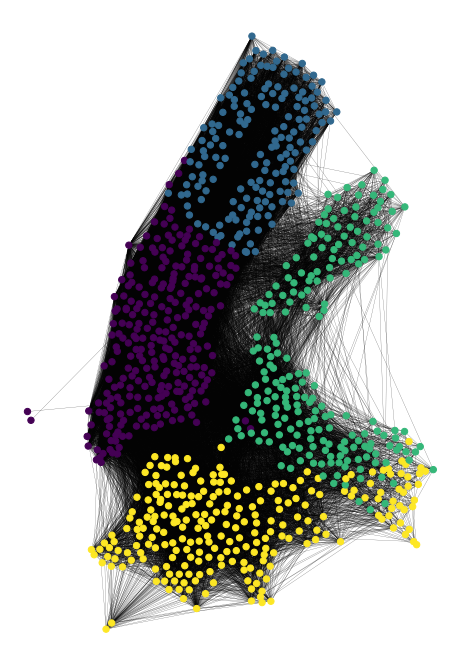

In [689]:
plt.figure(figsize=(8,12))

nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=l_c, cmap=cmap)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

## 9th-15th of March ##

In [730]:
# 9 -> Monday
# Choose day 
days = [9, 10, 11, 12, 13]
#days = [11]

# Find all connections with weights
adj_9_13_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_9_13_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_9_13_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 9 loaded...
Day 10 loaded...
Day 11 loaded...
Day 12 loaded...
Day 13 loaded...


In [731]:
print("Total number of rides : {}".format(np.sum(adj_9_13_tot) / 2))

Total number of rides : 289536.0


In [732]:
adj_9_13 = adj_9_13_tot.copy()
adj_9_13[adj_9_13 < ths] = 0
adj_9_13[adj_9_13 >= ths] = 1

print("Unweighted number of rides : {}".format(np.sum(adj_9_13) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_9_13[i, i] = 0

Unweighted number of rides : 70933.5


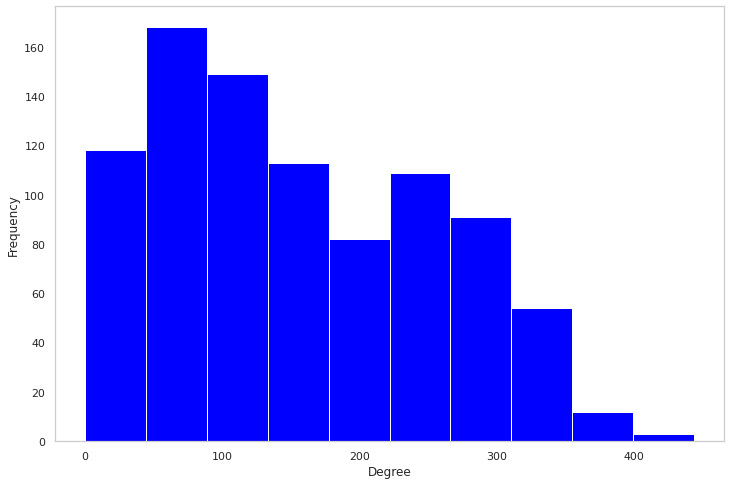

In [733]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_9_13 = nx.from_numpy_matrix(adj_9_13)
g_9_13_tot = nx.from_numpy_matrix(adj_9_13)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_9_13 = np.array([x[1] for x in g_9_13.degree])
_ = plt.hist(degs_9_13, color='blue')
plt.savefig('./plots/degree_9_15.eps')

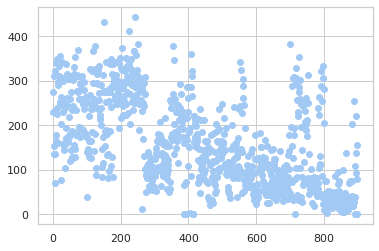

In [734]:
plt.scatter(np.arange(n_tot_station), degs_9_13)

## Plot ##

In [739]:
ks = [4,5,6]
metrics = {}
for k in ks:
    metrics[k] = []
    perf = []
    cov  = []
    for i in range(10):
        c_g = list(asyn_fluidc(g_2_6, k))
        perf.append(performance(g_2_6, c_g))
        cov.append(coverage(g_2_6, c_g))
    metrics[k].append(np.array(perf))
    metrics[k].append(np.array(cov))
    
    print("\n")
    
    print("Average Performance with {} clusters : {}".format(k, np.mean(np.array(perf))))
    print("Std on Performance with {} clusters : {}".format(k, np.std(np.array(perf))))
    print("Average Coverage with {} clusters: {}".format(k, np.mean(np.array(cov))))
    print("Std on Coverage with {} clusters: {}".format(k, np.std(np.array(cov))))




Average Performance with 4 clusters : 0.7965696855460636
Std on Performance with 4 clusters : 0.013020798554156983
Average Coverage with 4 clusters: 0.7503857264231096
Std on Coverage with 4 clusters: 0.05952941965789633


Average Performance with 5 clusters : 0.8276953556481116
Std on Performance with 5 clusters : 0.020408266952496354
Average Coverage with 5 clusters: 0.7320849617672047
Std on Coverage with 5 clusters: 0.04407179767044464


Average Performance with 6 clusters : 0.8546762735739113
Std on Performance with 6 clusters : 0.005195746622095881
Average Coverage with 6 clusters: 0.664642310960068
Std on Coverage with 6 clusters: 0.037124826599847664


In [740]:
cols = {}
for i in range(len(c_g)):
    for node in c_g[i]:
        cols[node] = i

l_c = [cols[e] for e in sorted(list(cols.keys()))]

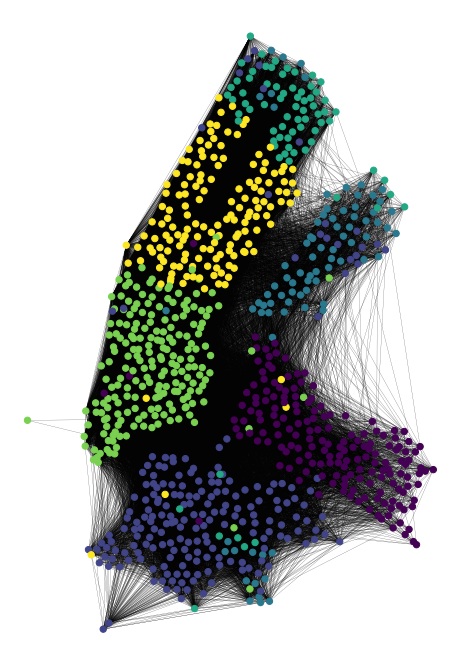

In [745]:
plt.figure(figsize=(8,12))

nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=l_c, cmap=cmap)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

### Clustering ###

In [735]:
isolated_nodes_9_13 = []
for e in nx.connected_components(g_9_13):
    if len(e) < 3:
        isolated_nodes_9_13.append(e.pop())

g_9_13.remove_nodes_from(isolated_nodes_9_13)

for e in nx.connected_components(g_9_13):
    if len(e) < 3:
        print(e)

In [736]:
G_9_13 = pygsp.graphs.Graph(nx.adjacency_matrix(g_9_13))

G_9_13.compute_laplacian()
G_9_13.compute_fourier_basis()

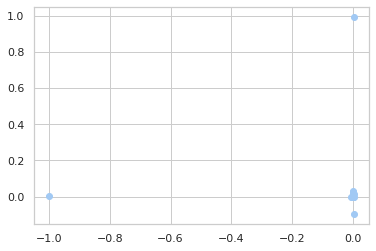

In [737]:
plt.scatter(G_9_13.U[:,1], G_9_13.U[:,2])

In [746]:
G_9_13.e

array([  0.        ,   1.99134157,   3.92292798,   3.98095492,
         4.92471143,   5.6888604 ,   8.54761451,   9.59526354,
         9.86213018,  10.48718154,  10.78583717,  11.93237129,
        13.16477339,  13.94664885,  14.41361348,  14.60547586,
        14.79418137,  15.10196257,  15.60895012,  16.11218861,
        17.23880283,  17.26858598,  17.5483733 ,  18.36795297,
        18.58088989,  19.06404745,  19.38901336,  19.65250338,
        19.89385319,  20.41107011,  20.8040246 ,  21.39025799,
        21.69257238,  21.91441469,  22.22409574,  22.89256191,
        22.98673465,  23.5614855 ,  23.91907   ,  24.54259867,
        24.74087447,  24.88871922,  25.11780422,  25.35917748,
        25.65412322,  25.72320674,  26.12214075,  26.31988079,
        26.39791593,  26.85432581,  27.23386351,  27.97457185,
        28.39532416,  28.55295532,  29.04491288,  29.217552  ,
        29.6361032 ,  30.26922683,  30.51052771,  30.68381437,
        31.0142081 ,  31.21731457,  31.24620926,  31.58

In [738]:
nx.algorithms.cluster.average_clustering(g_9_13)

0.46510119862397076

## 16th-22th of March ##

In [35]:
# 16 -> Monday
# Choose day 
days = [16, 17, 18, 19, 20, 21, 22]
#days = [18]

# Find all connections with weights
adj_16_20_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_16_20_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_16_20_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 16 loaded...
Day 17 loaded...
Day 18 loaded...
Day 19 loaded...
Day 20 loaded...
Day 21 loaded...
Day 22 loaded...


In [36]:
print("Total number of rides : {}".format(np.sum(adj_16_20_tot) / 2))

Total number of rides : 188080.0


In [37]:
adj_16_20 = adj_16_20_tot.copy()
adj_16_20[adj_16_20 < ths] = 0
adj_16_20[adj_16_20 >= ths] = 1

print("Unweighted number of rides : {}".format(np.sum(adj_16_20) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_16_20[i, i] = 0

Unweighted number of rides : 20604.5


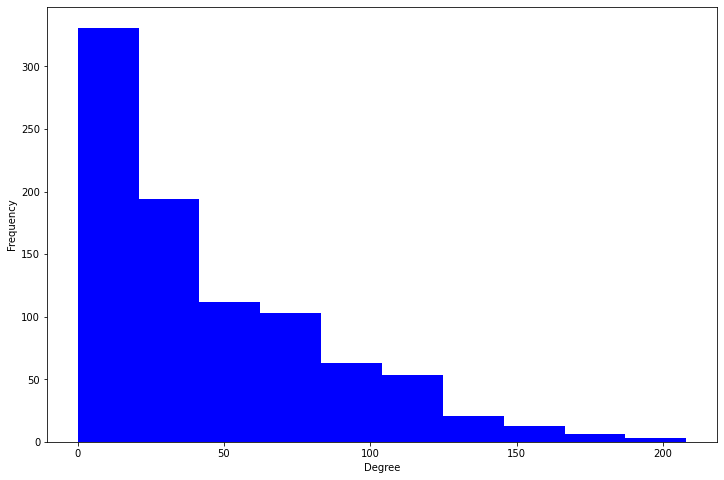

In [38]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_16_20 = nx.from_numpy_matrix(adj_16_20)
g_16_20_tot = nx.from_numpy_matrix(adj_16_20)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_16_20 = np.array([x[1] for x in g_16_20.degree])
_ = plt.hist(degs_16_20, color='blue')
plt.savefig('./plots/degree_16_22.eps')

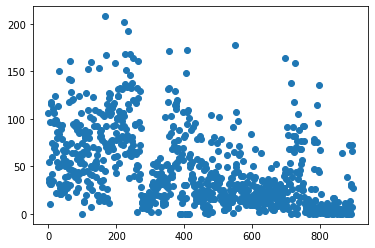

In [39]:
plt.scatter(np.arange(n_tot_station), degs_16_20)

## Plot ## 

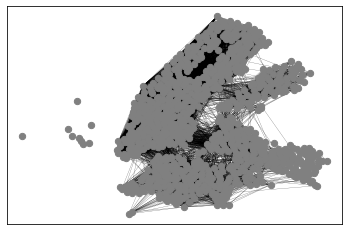

In [40]:
fig, ax = plt.subplots()

nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color='gray', ax=ax)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)

# mplleaflet.show()

### Clustering ###

In [41]:
isolated_nodes_16_20 = []
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        isolated_nodes_16_20.append(e.pop())

g_16_20.remove_nodes_from(isolated_nodes_16_20)

for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        print(e)

{811}
{869}
{870}
{879}


In [42]:
isolated_nodes_16_20_ = []
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        isolated_nodes_16_20_.append(e.pop())
g_16_20.remove_nodes_from(isolated_nodes_16_20_)

In [43]:
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        print(e)

In [44]:
isolated_nodes_16_20.extend(isolated_nodes_16_20_)

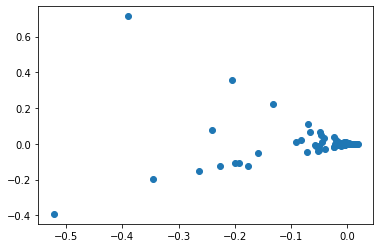

In [45]:
G_16_20 = pygsp.graphs.Graph(nx.adjacency_matrix(g_16_20))

G_16_20.compute_laplacian()
G_16_20.compute_fourier_basis()

plt.scatter(G_16_20.U[:,1], G_16_20.U[:,2])

In [46]:
nx.algorithms.cluster.average_clustering(g_16_20)

0.352592474866824

## 23st-29th of March ##

In [720]:
# 23 -> Monday
# Choose day 
days = [23, 24, 25, 26, 27]
#days = [24]

# Find all connections with weights
adj_23_27_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_23_27_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_23_27_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 23 loaded...
Day 24 loaded...
Day 25 loaded...
Day 26 loaded...
Day 27 loaded...


In [721]:
print("Total number of rides : {}".format(np.sum(adj_23_27_tot) / 2))

Total number of rides : 85428.0


In [722]:
adj_23_27 = adj_23_27_tot.copy()
adj_23_27[adj_23_27 < ths] = 0
adj_23_27[adj_23_27 >= ths] = 1
print("Unweighted number of rides : {}".format(np.sum(adj_23_27) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_23_27[i, i] = 0

Unweighted number of rides : 34634.5


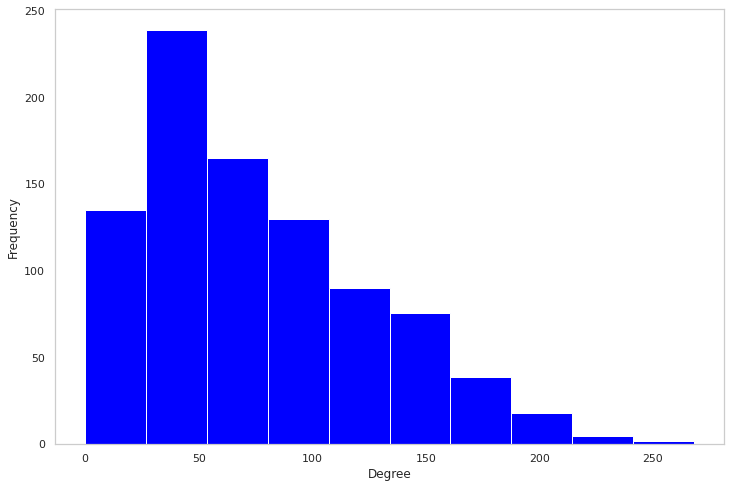

In [723]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_23_27 = nx.from_numpy_matrix(adj_23_27)
g_23_27_tot = nx.from_numpy_matrix(adj_23_27)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_23_27 = np.array([x[1] for x in g_23_27.degree])
_ = plt.hist(degs_23_27, color='blue')
plt.savefig('./plots/degree_23_29.eps')

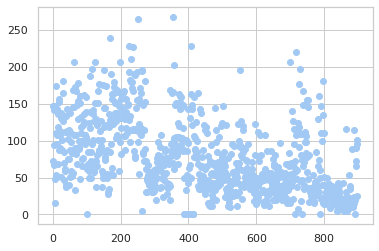

In [724]:
plt.scatter(np.arange(n_tot_station), degs_23_27)

## Plot ##

In [520]:
from networkx.algorithms.community.quality import coverage

In [729]:
ks = [4,5,6]
metrics = {}
for k in ks:
    metrics[k] = []
    perf = []
    cov  = []
    for i in range(10):
        c_g = list(asyn_fluidc(g_23_27, k))
        perf.append(performance(g_23_27, c_g))
        cov.append(coverage(g_23_27, c_g))
    metrics[k].append(np.array(perf))
    metrics[k].append(np.array(cov))
    
    print("\n")
    
    print("Average Performance with {} clusters : {}".format(k, np.mean(np.array(perf))))
    print("Std on Performance with {} clusters : {}".format(k, np.std(np.array(perf))))
    print("Average Coverage with {} clusters: {}".format(k, np.mean(np.array(cov))))
    print("Std on Coverage with {} clusters: {}".format(k, np.std(np.array(cov))))




Average Performance with 4 clusters : 0.7804166986220825
Std on Performance with 4 clusters : 0.015657311003948456
Average Coverage with 4 clusters: 0.7312750109537023
Std on Coverage with 4 clusters: 0.03177375220560971


Average Performance with 5 clusters : 0.8177076462918936
Std on Performance with 5 clusters : 0.006204392121523345
Average Coverage with 5 clusters: 0.6805024098145173
Std on Coverage with 5 clusters: 0.03457588341600121


Average Performance with 6 clusters : 0.8385032083237467
Std on Performance with 6 clusters : 0.004530540725178515
Average Coverage with 6 clusters: 0.6412238936760625
Std on Coverage with 6 clusters: 0.042668668305589214


In [742]:
cols = {}
for i in range(len(c_g)):
    for node in c_g[i]:
        cols[node] = i

l_c = [cols[e] for e in sorted(list(cols.keys()))]

ValueError: 'c' argument has 889 elements, which is inconsistent with 'x' and 'y' with size 885.

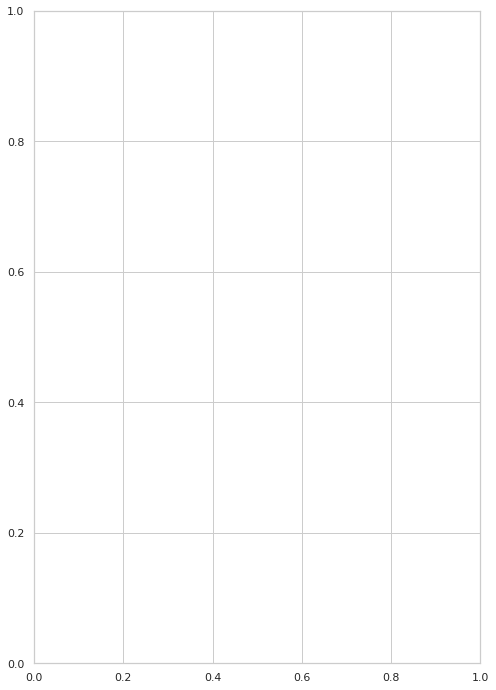

In [743]:
plt.figure(figsize=(8,12))

nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=l_c, cmap=cmap)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

### Clustering ###

In [726]:
isolated_nodes_23_27 = []
for e in nx.connected_components(g_23_27):
    if len(e) < 3:
        isolated_nodes_23_27.append(e.pop())

g_23_27.remove_nodes_from(isolated_nodes_23_27)

for e in nx.connected_components(g_23_27):
    if len(e) < 3:
        print(e)

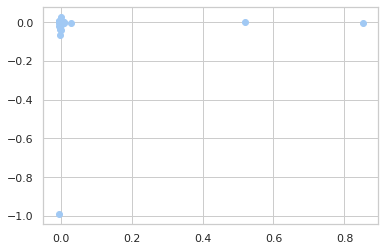

In [727]:
G_23_27 = pygsp.graphs.Graph(nx.adjacency_matrix(g_23_27))

G_23_27.compute_laplacian()
G_23_27.compute_fourier_basis()

plt.scatter(G_23_27.U[:,1], G_23_27.U[:,2])

In [728]:
nx.algorithms.cluster.average_clustering(g_23_27)

0.30332337421400735

## Deg-Sorted Nodes over time ##

In [56]:
sort_deg = np.argsort(degs_2_6)

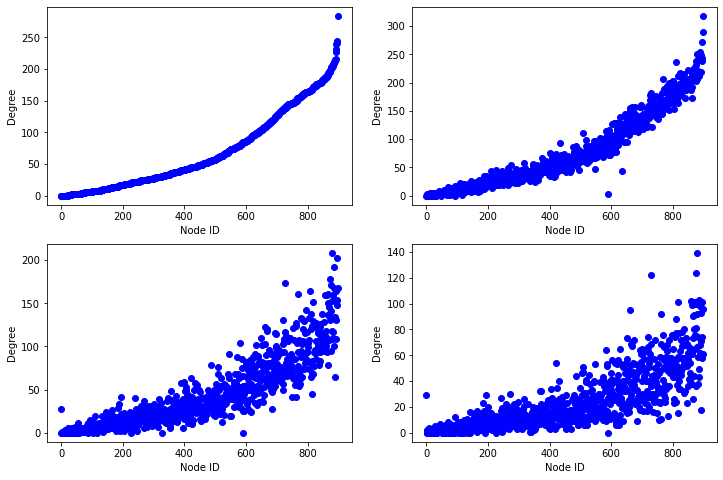

In [57]:
plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.scatter(np.arange(n_tot_station), degs_2_6[sort_deg], color='blue')
plt.xlabel('Node ID')
plt.ylabel('Degree')
plt.grid(False)

plt.subplot(2,2,2)
plt.scatter(np.arange(n_tot_station), degs_9_13[sort_deg], color='blue')
plt.xlabel('Node ID')
plt.ylabel('Degree')
plt.grid(False)

plt.subplot(2,2,3)
plt.scatter(np.arange(n_tot_station), degs_16_20[sort_deg], color='blue')
plt.xlabel('Node ID')
plt.ylabel('Degree')
plt.grid(False)

plt.subplot(2,2,4)
plt.scatter(np.arange(n_tot_station), degs_23_27[sort_deg], color='blue')
plt.xlabel('Node ID')
plt.ylabel('Degree')
plt.grid(False)

plt.savefig('./plots/degree_order.eps')

# Functions on Graphs #

In [58]:
f_2_6 = np.sum(adj_2_6_tot, axis=0)
f_9_13 = np.sum(adj_9_13_tot, axis=0)
f_16_20 = np.sum(adj_16_20_tot, axis=0)
f_23_27 = np.sum(adj_23_27_tot, axis=0)

f_2_6 = np.delete(f_2_6, isolated_nodes_2_6)
f_9_13 = np.delete(f_9_13, isolated_nodes_9_13)
f_16_20 = np.delete(f_16_20, isolated_nodes_16_20)
f_23_27 = np.delete(f_23_27, isolated_nodes_23_27)


In [59]:
d_2_6 = np.delete(degs_2_6, isolated_nodes_2_6)
d_9_13 = np.delete(degs_9_13, isolated_nodes_9_13)
d_16_20 = np.delete(degs_16_20, isolated_nodes_16_20)
d_23_27 = np.delete(degs_23_27, isolated_nodes_23_27)

In [387]:
cmap = plt.cm.get_cmap('hot')

In [388]:
print(np.max(f_2_6))
print(np.max(f_9_13))
print(np.max(f_16_20))
print(np.max(f_23_27))

print(np.min(f_2_6))
print(np.min(f_9_13))
print(np.min(f_16_20))
print(np.min(f_23_27))

5515.0
5329.0
2675.0
1490.0
11.0
9.0
11.0
9.0


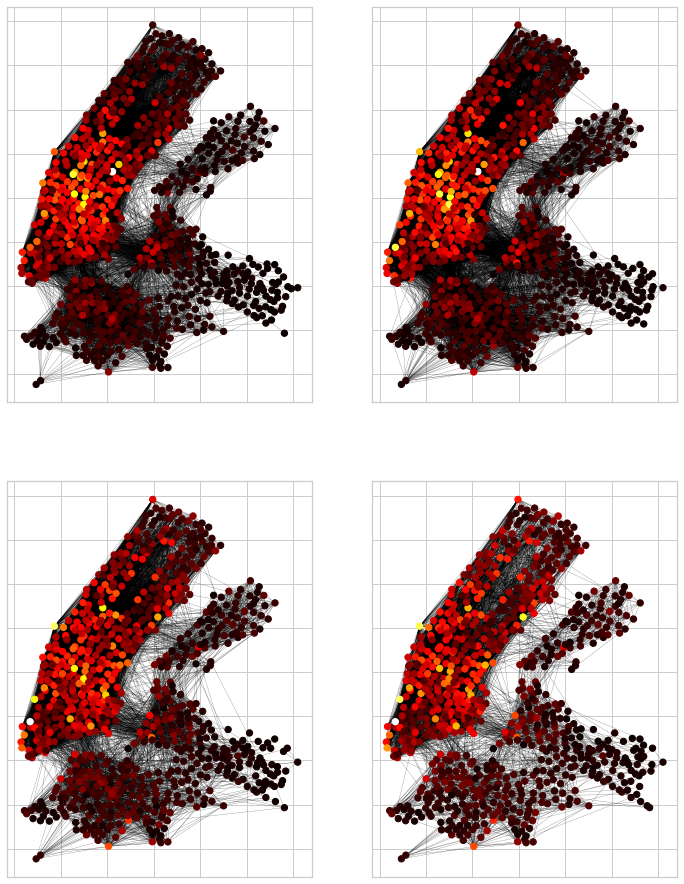

In [389]:
plt.figure(figsize=(12,16))
plt.subplot(2,2,1)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=f_2_6, cmap=cmap, )
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=f_9_13, cmap=cmap)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=f_16_20, cmap=cmap)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=f_23_27, cmap=cmap)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')



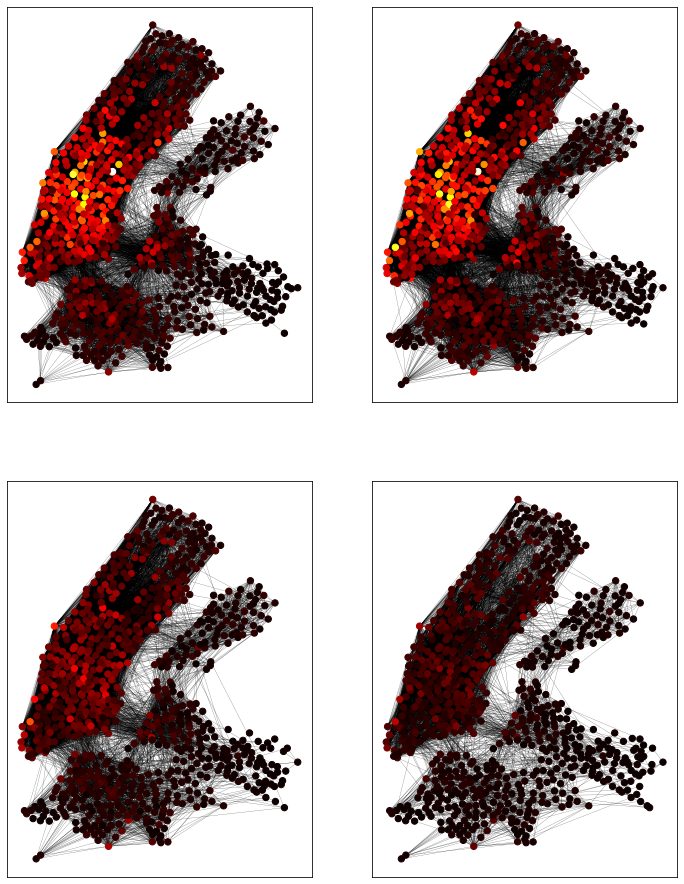

In [63]:
plt.figure(figsize=(12,16))
plt.subplot(2,2,1)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=f_2_6, cmap=cmap, vmin=7, vmax=5515)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=f_9_13, cmap=cmap, vmin=7, vmax=5515)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=f_16_20, cmap=cmap, vmin=7, vmax=5515)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=f_23_27, cmap=cmap, vmin=7, vmax=5515)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')



In [64]:
print(np.max(d_2_6))
print(np.max(d_9_13))
print(np.max(d_16_20))
print(np.max(d_23_27))

print(np.min(d_2_6))
print(np.min(d_9_13))
print(np.min(d_16_20))
print(np.min(d_23_27))

284
318
208
139
1
1
1
1


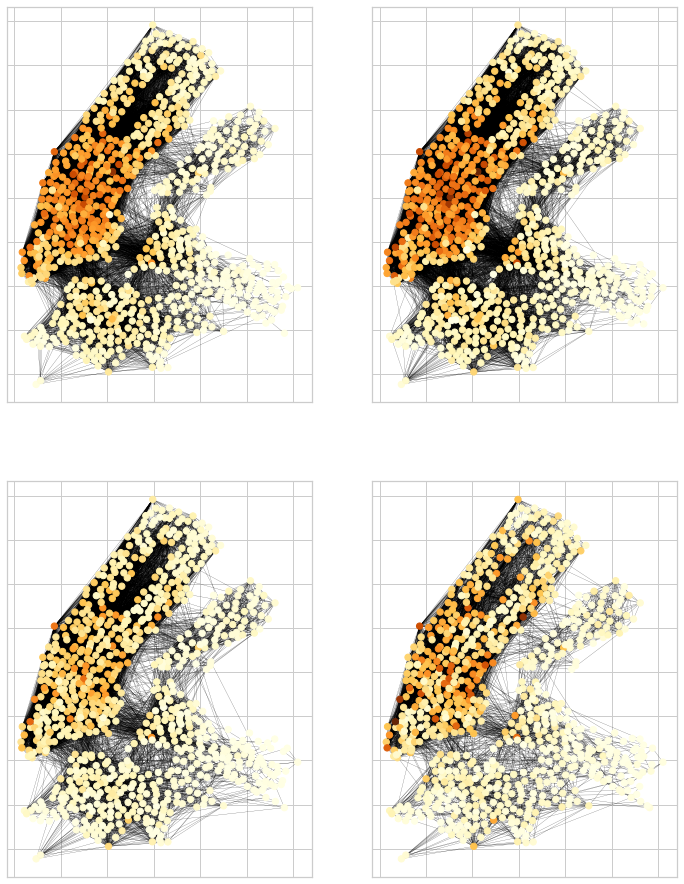

In [386]:
plt.figure(figsize=(12,16))
plt.subplot(2,2,1)

nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=d_2_6, cmap=cmap, vmin=1, vmax=318)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=d_9_13, cmap=cmap, vmin=1, vmax=318)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=d_16_20, cmap=cmap, vmin=1, vmax=318)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=d_23_27, cmap=cmap, vmin=1, vmax=318)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

# 1) Temporal Analysis # 

## Weekly days #

In [66]:
# First Week 
hour_full_2_8 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [2, 3, 4, 5, 6, 7, 8]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_2_8.extend(h_rides)
    # plt.plot(h_rides)
    j += 1
    1

In [67]:
# Second Week
hour_full_9_15 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [9, 10, 11, 12, 13, 14, 15]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_9_15.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [68]:
# Third Week
hour_full_16_22 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [16, 17, 18, 19, 20, 21, 22]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_16_22.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [69]:
# Fourth Week
hour_full_23_29 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [23, 24, 25, 26, 27, 28, 29]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_23_29.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [70]:
full_month = []
full_month.extend(hour_full_2_8)
full_month.extend(hour_full_9_15)
full_month.extend(hour_full_16_22)
full_month.extend(hour_full_23_29)

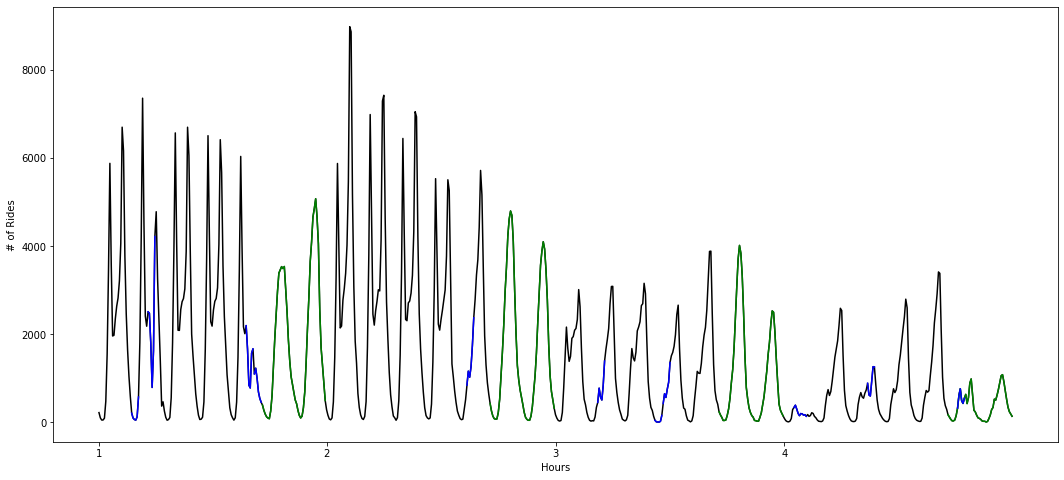

In [71]:
plt.figure(figsize=(18,8))
_ = plt.plot(full_month, color='black')
_ = plt.plot(np.arange(120, 167), hour_full_2_8[120:], color='green')
_ = plt.plot(np.arange(287, 335), hour_full_9_15[120:], color='green')
_ = plt.plot(np.arange(455, 503), hour_full_16_22[120:], color='green')
_ = plt.plot(np.arange(623, 671), hour_full_23_29[120:], color='green')


_ = plt.plot(np.arange(24, 30), full_month[24:30], color='blue')
_ = plt.plot(np.arange(36, 42), full_month[36:42], color='blue')
_ = plt.plot(np.arange(108, 114), full_month[108:114], color='blue')
_ = plt.plot(np.arange(114, 120), full_month[114:120], color='blue')
_ = plt.plot(np.arange(270, 276), full_month[270:276], color='blue')
_ = plt.plot(np.arange(366, 372), full_month[366:372], color='blue')
_ = plt.plot(np.arange(408, 414), full_month[408:414], color='blue')
_ = plt.plot(np.arange(414, 420), full_month[414:420], color='blue')
_ = plt.plot(np.arange(510, 516), full_month[510:516], color='blue')
_ = plt.plot(np.arange(516, 520), full_month[516:520], color='blue')
_ = plt.plot(np.arange(564, 570), full_month[564:570], color='blue')
_ = plt.plot(np.arange(630, 636), full_month[630:636], color='blue')


_ = plt.xticks([0, 167, 335, 503], np.arange(1, 5))

_ = plt.xlabel('Hours')
_ = plt.ylabel('# of Rides')
plt.grid(False)
plt.savefig('./plots/hours_rides.eps')

# Trip Duration #

In [72]:
td = []
days = np.arange(1, 31)
out = []
for day in days:
    ti = []
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        if row['tripduration'] < 3600:
            ti.append(row['tripduration'] )
        else:
            out.append(row['tripduration'])
    td.append(ti)

    

In [73]:
m = []
for e in td:
    e = np.array(e)
    m.append(np.mean(e))
    

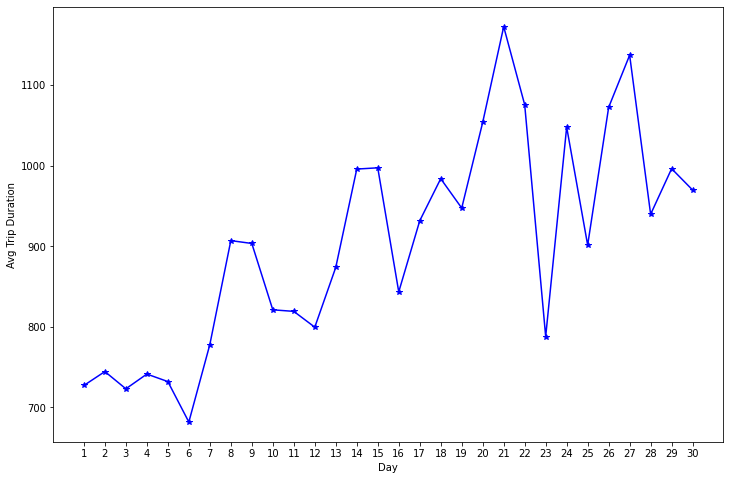

In [74]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(1, 31), m, color='blue', marker='*')
_ = plt.xticks(np.arange(1, 31), np.arange(1, 31))
plt.xlabel('Day')
plt.ylabel('Avg Trip Duration')
plt.grid(False)
plt.savefig('./plots/time_duration_mean.eps')

In [76]:
first = []
for e in [2,3,4,5,6,8]:
    first.extend(td[e])
first = np.array(first)
m_f = np.mean(first)
s_f = np.std(first)

In [77]:
second = []
for e in [9, 10, 11, 12, 13, 14, 15]:
    second.extend(td[e])
second = np.array(second)
m_s = np.mean(second)
s_s = np.std(second)

In [78]:
third = []
for e in [16, 17, 18, 19, 20, 21, 22]:
    third.extend(td[e])
third = np.array(third)
m_t = np.mean(third)
s_t = np.std(third)

In [79]:
q = []
for e in [23, 24, 25, 26, 27, 28, 29] :
    q.extend(td[e])
q = np.array(q)
m_q = np.mean(q)
s_q = np.std(q)

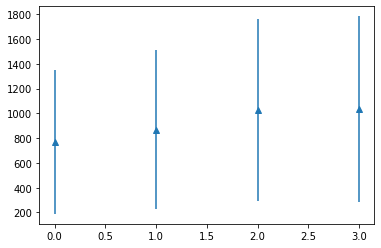

In [80]:
means = [m_f, m_s, m_t, m_q]
ss = [s_f, s_s, s_t, s_q]
x = np.arange(4)

plt.errorbar(x, means, ss, linestyle='None', marker='^')

plt.show()

In [81]:
int(280/100)

2

In [82]:
mat_time = np.zeros((36, 30))
i = 0
for e in td:
    for a in e:
        mat_time[int(a/100),i] += 1
    i += 1
    
    

In [83]:
mat_time /= np.sum(mat_time, axis=0)

mat_time = np.cumsum(mat_time, axis=0)

In [84]:
len(out)

15386

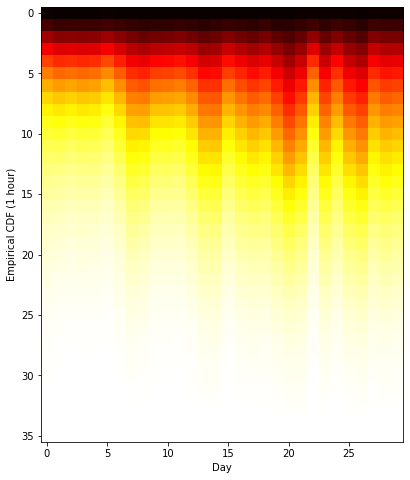

In [85]:
plt.figure(figsize=(12, 8))
plt.imshow(mat_time, cmap='hot')
plt.grid(False)
plt.xlabel('Day')
plt.ylabel('Empirical CDF (1 hour)')
plt.savefig('./plots/cdf_timeduration.eps')

# Different Ratio Graphs # 

In [86]:
ths = 1

Day 3 loaded...
Unweighted number of rides (edges) : 25858.5


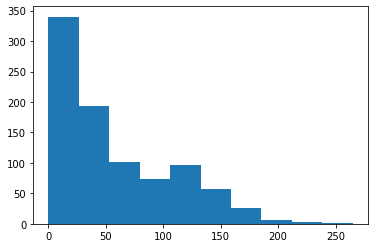

In [87]:
# Wednesday 4

days = [3]

# Find all connections with weights
adj_4_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_4_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_4_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_4 = adj_4_tot.copy()
    
adj_4[adj_4 < ths] = 0
adj_4[adj_4 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_4) / 2))

for i in range(n_tot_station):
    adj_4[i, i] = 0

# Create Undirected graph 
g_4 = nx.from_numpy_matrix(adj_4)
degs_4 = np.array([x[1] for x in g_4.degree])
_ = plt.hist(degs_4)

Day 8 loaded...
Unweighted number of rides (edges) : 24228.0


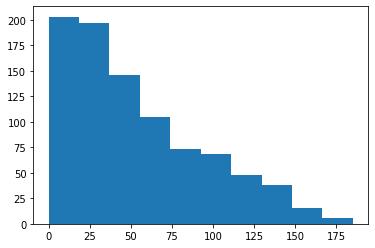

In [88]:
# Sunday 8

days = [8]

# Find all connections with weights
adj_8_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_8_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_8_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_8 = adj_8_tot.copy()
    
adj_8[adj_8 < ths] = 0
adj_8[adj_8 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_8) / 2))

for i in range(n_tot_station):
    adj_8[i, i] = 0

# Create Undirected graph 
g_8 = nx.from_numpy_matrix(adj_8)
degs_8 = np.array([x[1] for x in g_8.degree])
_ = plt.hist(degs_8)

Day 12 loaded...
Unweighted number of rides (edges) : 28021.0


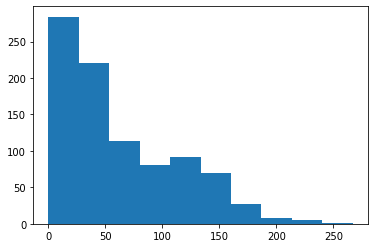

In [89]:
# Thursday 12

days = [12]

# Find all connections with weights
adj_12_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_12_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_12_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_12 = adj_12_tot.copy()
    
adj_12[adj_12 < ths] = 0
adj_12[adj_12 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_12) / 2))

for i in range(n_tot_station):
    adj_12[i, i] = 0

# Create Undirected graph 
g_12 = nx.from_numpy_matrix(adj_12)
degs_12 = np.array([x[1] for x in g_12.degree])
_ = plt.hist(degs_12)

Day 14 loaded...
Unweighted number of rides (edges) : 23704.5


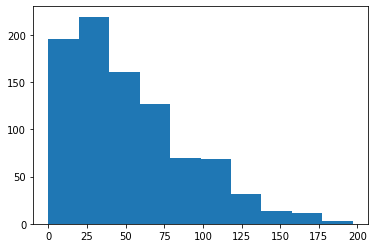

In [90]:
# Saturday 14

days = [14]

# Find all connections with weights
adj_14_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_14_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_14_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_14 = adj_14_tot.copy()
    
adj_14[adj_14 < ths] = 0
adj_14[adj_14 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_14) / 2))

for i in range(n_tot_station):
    adj_14[i, i] = 0

# Create Undirected graph 
g_14 = nx.from_numpy_matrix(adj_14)
degs_14 = np.array([x[1] for x in g_14.degree])
_ = plt.hist(degs_14)

Day 18 loaded...
Unweighted number of rides (edges) : 18562.5


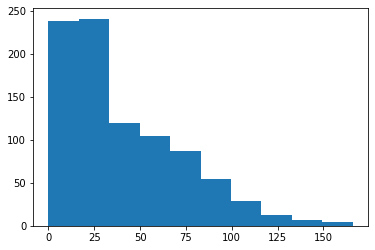

In [91]:
# Wed 18

days = [18]

# Find all connections with weights
adj_18_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_18_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_18_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_18 = adj_18_tot.copy()
    
adj_18[adj_18 < ths] = 0
adj_18[adj_18 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_18) / 2))

for i in range(n_tot_station):
    adj_18[i, i] = 0

# Create Undirected graph 
g_18 = nx.from_numpy_matrix(adj_18)
degs_18 = np.array([x[1] for x in g_18.degree])
_ = plt.hist(degs_18)

Day 21 loaded...
Unweighted number of rides (edges) : 17952.5


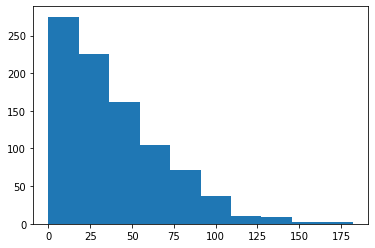

In [92]:
# Saturday 14

days = [21]

# Find all connections with weights
adj_21_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_21_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_21_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_21 = adj_21_tot.copy()
    
adj_21[adj_21 < ths] = 0
adj_21[adj_21 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_21) / 2))

for i in range(n_tot_station):
    adj_21[i, i] = 0

# Create Undirected graph 
g_21 = nx.from_numpy_matrix(adj_21)
degs_21 = np.array([x[1] for x in g_21.degree])
_ = plt.hist(degs_21)

Day 24 loaded...
Unweighted number of rides (edges) : 13160.5


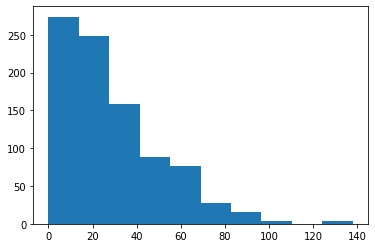

In [93]:
# Saturday 14

days = [24]

# Find all connections with weights
adj_24_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_24_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_24_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_24 = adj_24_tot.copy()
    
adj_24[adj_24 < ths] = 0
adj_24[adj_24 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_24) / 2))

for i in range(n_tot_station):
    adj_24[i, i] = 0

# Create Undirected graph 
g_24 = nx.from_numpy_matrix(adj_24)
degs_24 = np.array([x[1] for x in g_24.degree])
_ = plt.hist(degs_24)

Day 29 loaded...
Unweighted number of rides (edges) : 6697.5


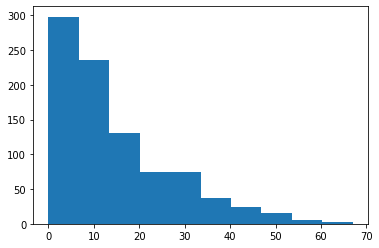

In [94]:
# Saturday 14

days = [29]

# Find all connections with weights
adj_29_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_29_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_29_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_29 = adj_29_tot.copy()
    
adj_29[adj_29 < ths] = 0
adj_29[adj_29 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_29) / 2))

for i in range(n_tot_station):
    adj_29[i, i] = 0

# Create Undirected graph 
g_29 = nx.from_numpy_matrix(adj_29)
degs_29 = np.array([x[1] for x in g_29.degree])
_ = plt.hist(degs_29)

In [95]:
f_4 = np.sum(adj_4_tot, axis=0)
f_8 = np.sum(adj_8_tot, axis=0)
f_12 = np.sum(adj_12_tot, axis=0)
f_14 = np.sum(adj_14_tot, axis=0)
f_18 = np.sum(adj_18_tot, axis=0)
f_21 = np.sum(adj_21_tot, axis=0)
f_24 = np.sum(adj_24_tot, axis=0)
f_29 = np.sum(adj_29_tot, axis=0)

In [96]:
import warnings
warnings.filterwarnings('ignore')

In [97]:
f_4[f_4 == 0] = 1

In [98]:
r_4 = f_4 / f_4
r_8 = f_8 / f_4
r_12 = f_12 / f_4
r_14 = f_14 / f_4
r_18 = f_18 / f_4
r_21 = f_21 / f_4
r_24 = f_24 / f_4
r_29 = f_29 / f_4

In [99]:
print(np.max(r_4))
print(np.max(r_8))
print(np.max(r_12))
print(np.max(r_14))
print(np.max(r_18))
print(np.max(r_21))
print(np.max(r_24))
print(np.max(r_29))

1.0
17.22222222222222
18.0
18.0
12.0
144.0
47.0
25.0


In [100]:
cmap = plt.cm.get_cmap('jet')

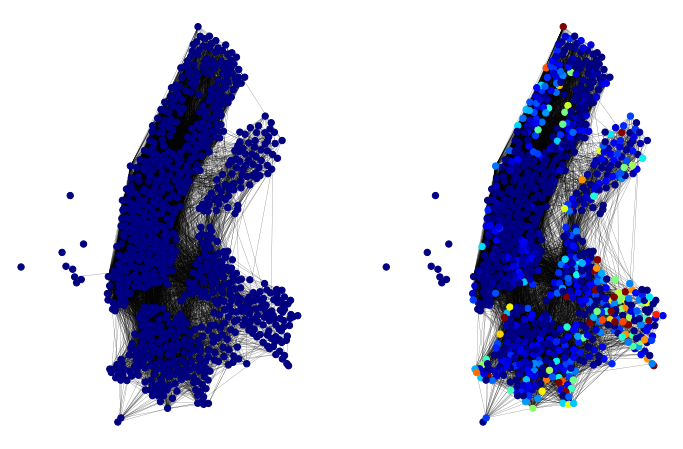

In [101]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_4, locations, node_size=40, node_color=r_4, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_4, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_8, locations, node_size=40, node_color=r_8, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_8, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/2_8_graph_1_5.jpeg')

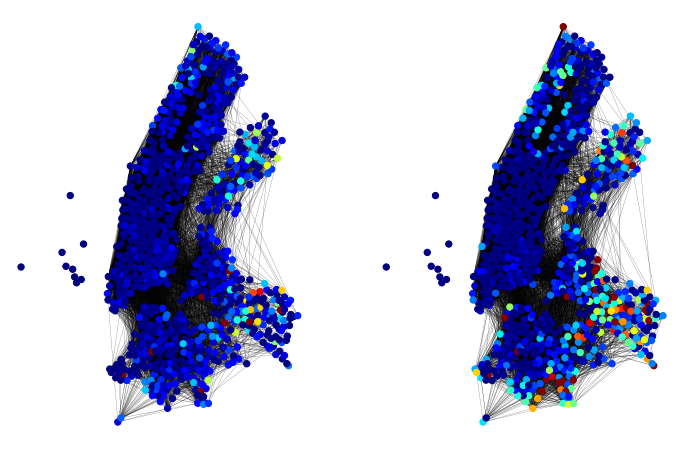

In [102]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_12, locations, node_size=40, node_color=r_12, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_12, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_14, locations, node_size=40, node_color=r_14, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_14, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/9_15_graph_1_5.jpeg')

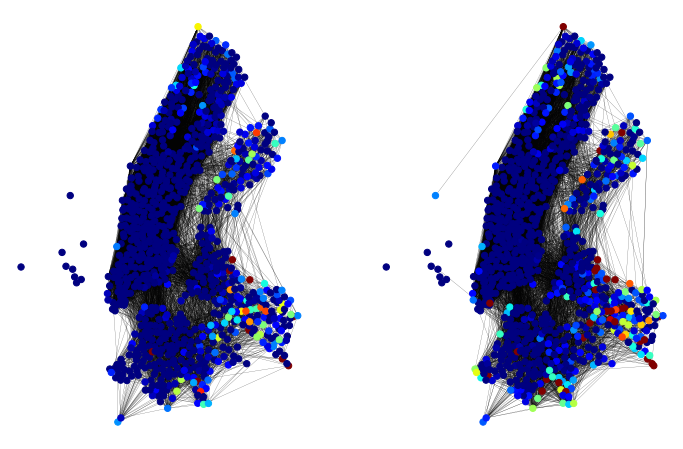

In [103]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_18, locations, node_size=40, node_color=r_18, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_18, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_21, locations, node_size=40, node_color=r_21, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_21, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/16_22_graph_1_5.jpeg')

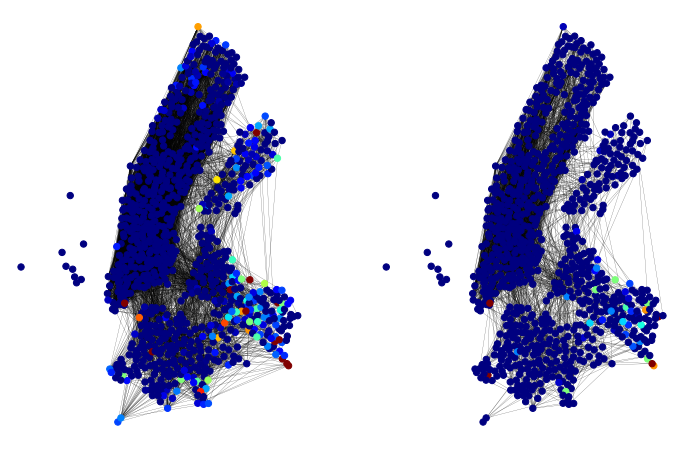

In [104]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_24, locations, node_size=40, node_color=r_24, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_24, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_29, locations, node_size=40, node_color=r_29, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_29, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/23_29_graph_1_5.jpeg')

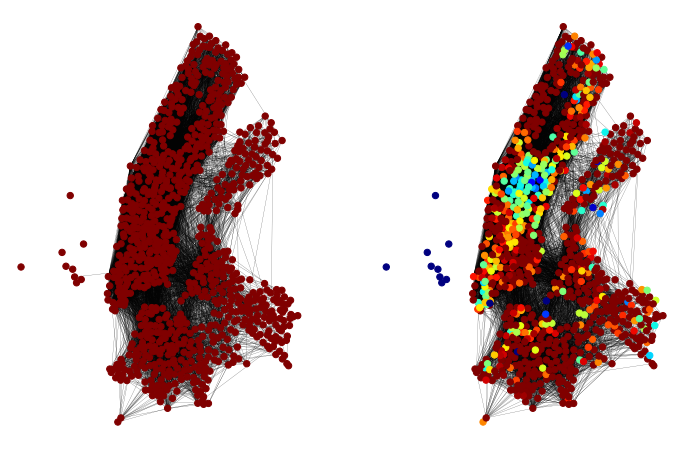

In [105]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_4, locations, node_size=40, node_color=r_4, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_4, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_8, locations, node_size=40, node_color=r_8, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_8, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/2_8_graph_0_1.jpeg')

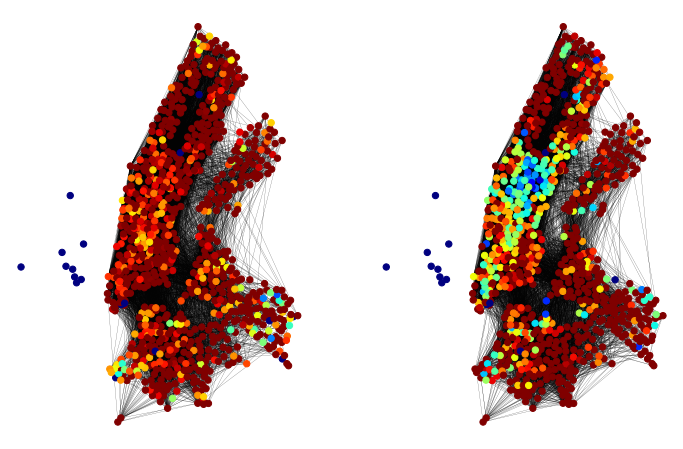

In [106]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_12, locations, node_size=40, node_color=r_12, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_12, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_14, locations, node_size=40, node_color=r_14, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_14, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/9_15_graph_0_1.jpeg')

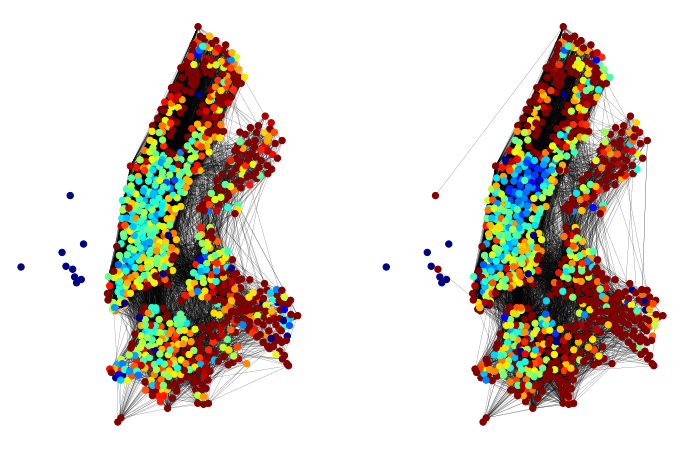

In [107]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_18, locations, node_size=40, node_color=r_18, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_18, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_21, locations, node_size=40, node_color=r_21, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_21, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/16_22_graph_0_1.jpeg')

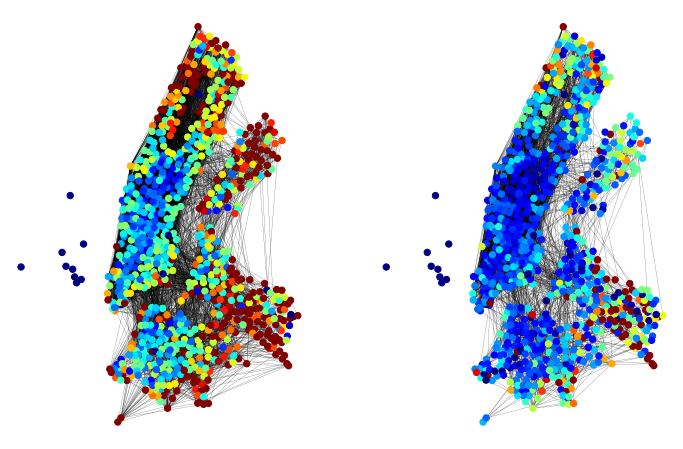

In [108]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_24, locations, node_size=40, node_color=r_24, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_24, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_29, locations, node_size=40, node_color=r_29, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_29, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/23_29_graph_0_1.jpeg')

In [109]:
l = [len(e) for k,e in hour_rides(d[3], d[4], df).items()]

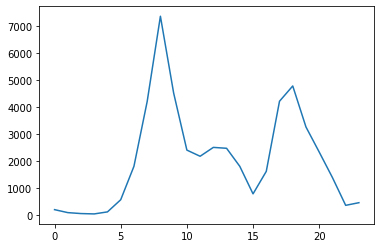

In [110]:
plt.plot(l)

Unweighted number of rides (edges) : 9223.5
Unweighted number of rides (edges) : 11883.0


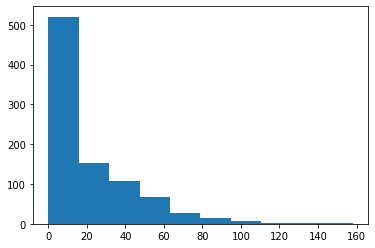

In [111]:
# Rush Hour Graph 8

# Tuesday 3

ths = 1
rides_3 = hour_rides(d[3], d[4], df)
rush_3_rides = rides_3[8]
rush_3_rides.extend(rides_3[9])

# Find all connections with weights
adj_3_rush_tot = np.zeros((n_tot_station, n_tot_station))
for index, row in df.iloc[rush_3_rides[0]:rush_3_rides[-1]].iterrows():
    adj_3_rush_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
    adj_3_rush_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1

adj_3_rush = adj_3_rush_tot.copy()
    
adj_3_rush[adj_3_rush < ths] = 0
adj_3_rush[adj_3_rush >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_3_rush) / 2))
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_3_rush_tot) / 2))

for i in range(n_tot_station):
    adj_3_rush[i, i] = 0

# Create Undirected graph 
g_3_rush = nx.from_numpy_matrix(adj_3_rush)
degs_3_rush = np.array([x[1] for x in g_3_rush.degree])
_ = plt.hist(degs_3_rush)

Unweighted number of rides (edges) : 4117.5
Unweighted number of rides (edges) : 4992.0


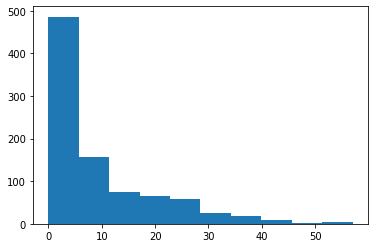

In [112]:
# Rush Hour Graph 8

# Wednesday 4

ths = 1
rides_3 = hour_rides(d[3], d[4], df)
calm_3_rides = rides_3[12]
calm_3_rides.extend(rides_3[13])

# Find all connections with weights
adj_3_calm_tot = np.zeros((n_tot_station, n_tot_station))
for index, row in df.iloc[calm_3_rides[0]:calm_3_rides[-1]].iterrows():
    adj_3_calm_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
    adj_3_calm_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1

adj_3_calm = adj_3_calm_tot.copy()
    
adj_3_calm[adj_3_calm < ths] = 0
adj_3_calm[adj_3_calm >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_3_calm) / 2))
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_3_calm_tot) / 2))

for i in range(n_tot_station):
    adj_3_calm[i, i] = 0

# Create Undirected graph 
g_3_calm = nx.from_numpy_matrix(adj_3_calm)
degs_3_calm = np.array([x[1] for x in g_3_calm.degree])
_ = plt.hist(degs_3_calm)

In [113]:
f_3_rush = np.sum(adj_3_rush_tot, axis=0)
f_3_calm = np.sum(adj_3_calm_tot, axis=0)

In [114]:
print(np.max(f_3_rush))
print(np.max(f_3_calm))

print(np.min(f_3_rush))
print(np.min(f_3_calm))

331.0
87.0
0.0
0.0


In [115]:
r_calm = f_3_calm / f_3_rush

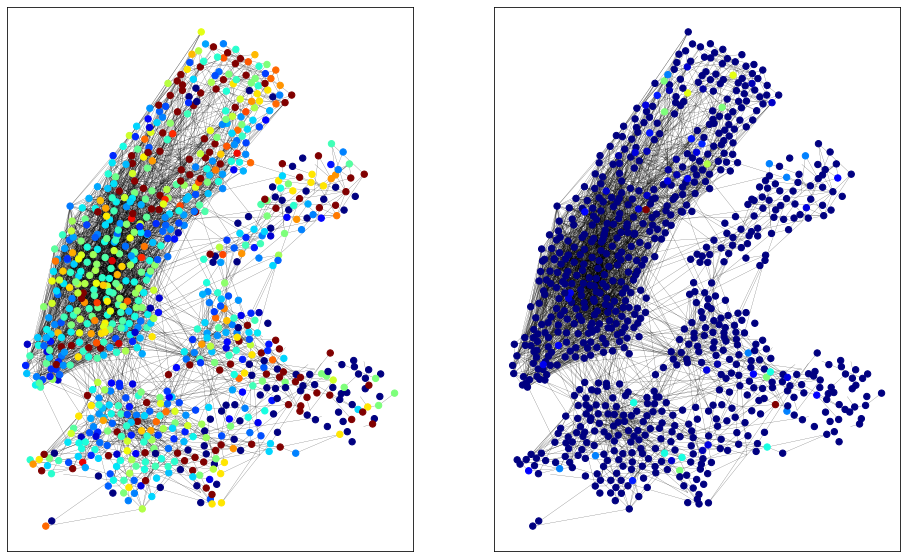

In [116]:
plt.figure(figsize=(16, 10))

plt.subplot(1,2,1)
nx.draw_networkx_nodes(g_3_calm, locations, node_size=40, node_color=r_calm, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_3_calm, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
nx.draw_networkx_nodes(g_3_calm, locations, node_size=40, node_color=r_calm, cmap=cmap,  vmin=1, vmax=5)
nx.draw_networkx_edges(g_3_calm, locations, alpha=0.8, width=0.2, edge_color='black')


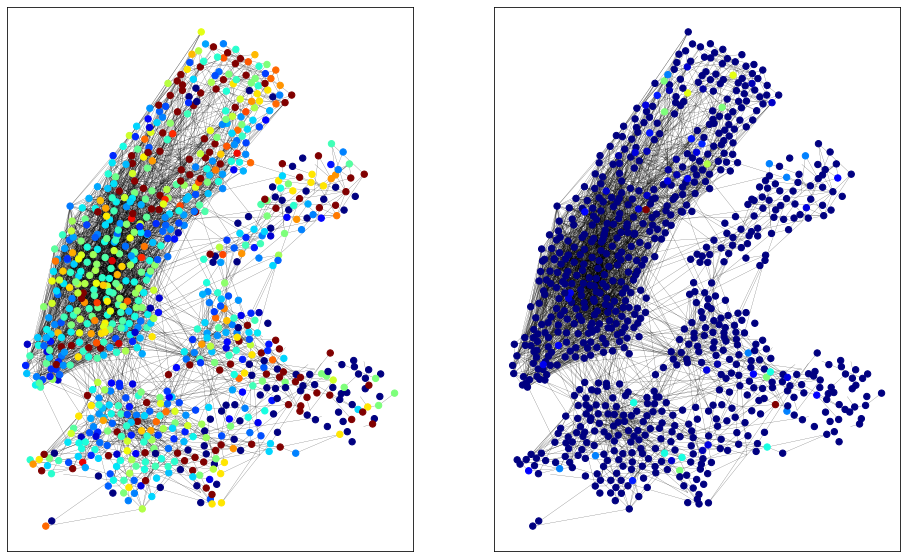

In [117]:
plt.figure(figsize=(16, 10))

plt.subplot(1,2,1)
nx.draw_networkx_nodes(g_3_calm, locations, node_size=40, node_color=r_calm, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_3_calm, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
nx.draw_networkx_nodes(g_3_calm, locations, node_size=40, node_color=r_calm, cmap=cmap,  vmin=1, vmax=5)
nx.draw_networkx_edges(g_3_calm, locations, alpha=0.8, width=0.2, edge_color='black')


# Heat Diffusion #

In [118]:
from pygsp.filters import Heat

In [378]:
source_nodes = [703]

In [379]:
t = np.arange(0, 100)

h = Heat(G_2_6, tau=t)

source = np.zeros(G_2_6.U.shape[0])
source[transform_source(source_nodes, isolated_nodes_2_6)] = 100

y_2_6 = h.filter(source)


In [380]:
for e in isolated_nodes_2_6:
    y_2_6 = np.insert(y_2_6, e, 0, axis=0)

In [381]:
t = np.arange(0, 100)

h = Heat(G_23_27, tau=t)

source = np.zeros(G_23_27.U.shape[0])
source[transform_source(source_nodes, isolated_nodes_23_27)] = 100

y_23_27 = h.filter(source)

In [382]:
for e in isolated_nodes_23_27:
    y_23_27 = np.insert(y_23_27, e, 0, axis=0)

In [383]:
hotmap = plt.cm.get_cmap('viridis')

In [384]:
len(g_2_6 )

877

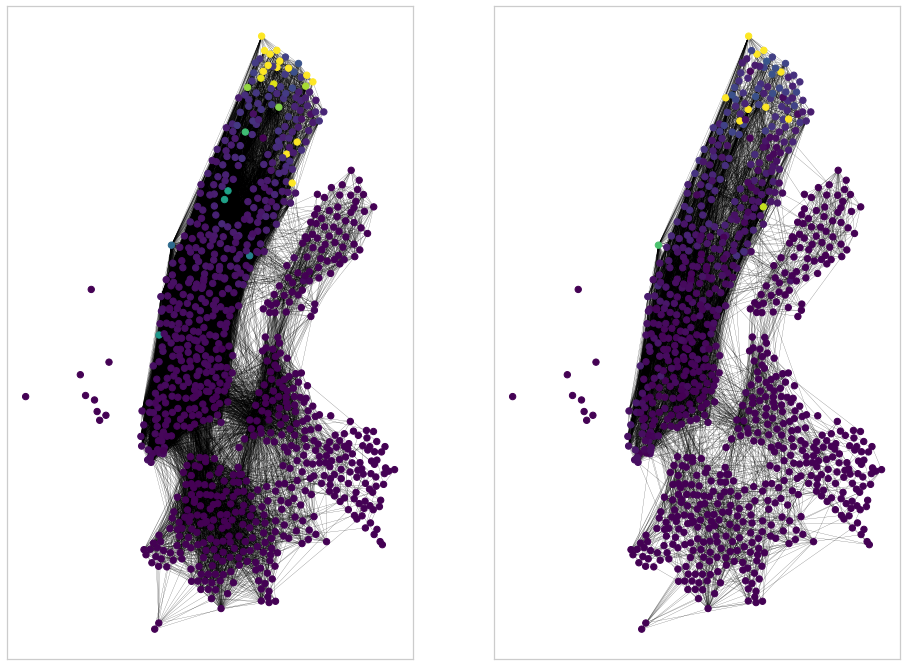

In [385]:
plt.figure(figsize=(16,12))


plt.subplot(1,2,1)
plt.grid(False)
nx.draw_networkx_nodes(g_2_6_tot, locations, node_size=40, node_color=y_2_6[:,8], cmap=hotmap, vim=0, vmax=1)
nx.draw_networkx_edges(g_2_6_tot, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
#plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))
plt.grid(False)
nx.draw_networkx_nodes(g_23_27_tot, locations, node_size=40, node_color=y_23_27[:,8], cmap=hotmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_23_27_tot, locations, alpha=0.8, width=0.2, edge_color='black')



# Metro Data #

In [363]:
# import shapefile as shp
import seaborn as sns
from pyproj import Proj, transform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from shapely.geometry import shape, Point

from utils.shapefile import read_shapefile, plot_shape, plot_map, plot_map_fill

In [269]:
# UTILS

def find_day_metro(day, month, df):
    day = str_int(day)
    month = str_int(month)
    ids = []
    for index, row in df.iterrows():
        if row['date'].split('-')[-1] == day and row['date'].split('-')[-2] == month:
            ids.append(index)
    return ids
        
def str_int(i):
    if i < 10:
        return '0' + str(i)
    else:
        return str(i)

def calc_color(data, num_bins=None, ref_bins=None, name='YlOrBr'):
    
    cmap=plt.get_cmap(name)
    
    if ref_bins is None:
        new_data, bins = pd.qcut(data, num_bins, retbins=True, labels=list(range(num_bins)))
    else:
        bins = ref_bins
        num_bins = len(ref_bins)-1
        new_data = pd.cut(data, ref_bins, include_lowest=True, labels=list(range(num_bins)))
    m = num_bins - 1
    color_ton = []
    for val in new_data:
        color_ton.append(matplotlib.colors.to_hex(cmap(val/m), keep_alpha=False)) 
    
    #plot color map
    
    cat = np.arange(num_bins)
    ex = cat / (num_bins-1)
    ex = np.expand_dims(ex, 0)
    
    plt.imshow(ex, cmap=cmap)
    plt.grid(False)
    plt.yticks([0], [''])
    _ = plt.axis('on')

    return color_ton, bins

In [253]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(12,8))

%matplotlib inline

sf = shp.Reader("./data/shapefiles_/ZIP_CODE_040114.dbf")

df_shape = read_shapefile(sf)

In [130]:
metro_data = pd.read_csv('./data/metro/metro_whole_station.csv')

In [131]:
metro_data.head()

stop_name daytime_routes division     line borough structure  \
0  Astoria - Ditmars Blvd            N W      BMT  Astoria       Q  Elevated   
1  Astoria - Ditmars Blvd            N W      BMT  Astoria       Q  Elevated   
2  Astoria - Ditmars Blvd            N W      BMT  Astoria       Q  Elevated   
3  Astoria - Ditmars Blvd            N W      BMT  Astoria       Q  Elevated   
4  Astoria - Ditmars Blvd            N W      BMT  Astoria       Q  Elevated   

   gtfs_longitude  gtfs_latitude complex_id        date  entries  exits  
0      -73.912034      40.775036          1  2020-01-01     7024   7060  
1      -73.912034      40.775036          1  2020-01-02    15234  12171  
2      -73.912034      40.775036          1  2020-01-03    15687  14586  
3      -73.912034      40.775036          1  2020-01-04     9324  10309  
4      -73.912034      40.775036          1  2020-01-05     7659   8371

In [288]:
# Find Geo-Coordinates for stations

stat_geo = {}
for index, row in metro_data.iterrows():
    coor = np.array([row['gtfs_longitude'], row['gtfs_latitude']])
    stat_geo[row['stop_name']] = coor
    
# Find xlim and ylim 
x_lim = [100, -100]
y_lim = [100, 0]
for k,v in locations.items():
    
    if v[0] < x_lim[0]:
        x_lim[0] = v[0]
    elif v[0] > x_lim[1]:
        x_lim[1] = v[0]
        
    if v[1] < y_lim[0]:
        y_lim[0] = v[1]
    elif v[1] > y_lim[1]:
        y_lim[1] = v[1]
        
        


In [289]:
# Find Zip Code for Stations

points = [(k, Point(v)) for k,v in stat_geo.items()]
multis = [(e.record[0], shape(e.shape.__geo_interface__)) for e in sf.shapeRecords()]

stat_zip = {}

for stat, pt in points:
    point = shape(pt)
    for zip_code, poly in multis:
        if point.within(poly): 
            stat_zip[stat] = zip_code

In [134]:
zip_index = dict(zip(df_shape['ZIPCODE'], np.arange(len(df_shape))))

In [135]:
import pickle 

In [136]:
# Create indexes for March 

"""march_ids = []
for d in range(1, 32):
    march_ids.append(find_day_metro(d, 3, metro_data))

with open('./data/python_variables/march_ids.pickle', 'wb') as file:
    pickle.dump(march_ids, file)
"""

"march_ids = []\nfor d in range(1, 32):\n    march_ids.append(find_day_metro(d, 3, metro_data))\n\nwith open('./data/python_variables/march_ids.pickle', 'wb') as file:\n    pickle.dump(march_ids, file)\n"

In [137]:
with open('./data/python_variables/march_ids.pickle', 'rb') as file:
    march_ids = pickle.load(file)

In [315]:
# Find Daily runs

days = [5, 12, 19, 26]

days_metro = dict()

for day in days:
    days_metro[day] = {}
    for index, row in metro_data.iloc[march_ids[day-1]].iterrows():
        zip_code = stat_zip.get(row['stop_name'])
        if zip_code is not None:
            if days_metro[day].get(zip_code) is None:
                days_metro[day][zip_code] = row['entries'] 
            else:
                days_metro[day][zip_code] += row['entries'] 
    print("Aggregated day {}".format(day))

# Collect By indexes

idxs = {}
for day in days:
    idxs[day] = []
    idxs[day].append(np.array([zip_index[str(e)] for e in days_metro[day].keys() ]))
    idxs[day].append(np.array(list(days_metro[day].values())))
    idxs[day].append(idxs[day][1] / idxs[5][1])

Aggregated day 5
Aggregated day 12
Aggregated day 19
Aggregated day 26


In [139]:
assert len(idxs[days[0]][1]) == len(idxs[days[0]][0])

In [142]:
i = 0
for e in d:
    if np.isnan(e):
        print(i)
    i += 1

In [303]:
ref, bins = pd.qcut(idxs[5][1], 10, retbins=True, labels=list(range(10)))

In [326]:
bins = np.linspace(0,1, 11)

In [327]:
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

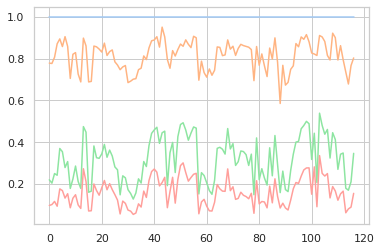

In [328]:
for k, v in idxs.items():
    plt.plot(v[2])

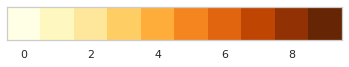

<Figure size 576x432 with 0 Axes>

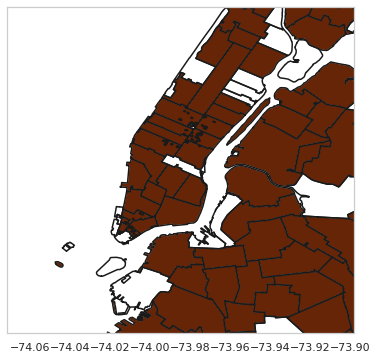

<Figure size 576x432 with 0 Axes>

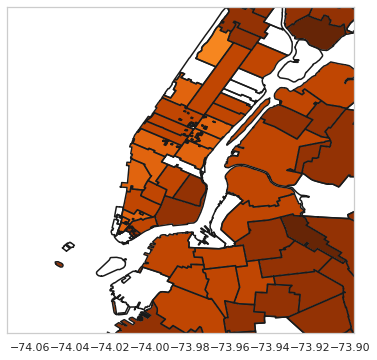

<Figure size 576x432 with 0 Axes>

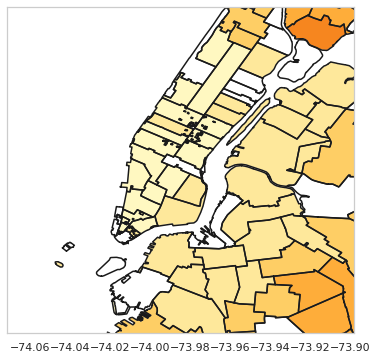

<Figure size 576x432 with 0 Axes>

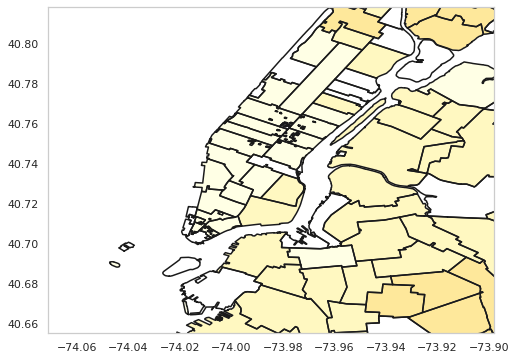

In [330]:
for k, v in idxs.items():
    
    color_ton, _ = calc_color(v[2], ref_bins=bins)

    ax = plot_map_fill(v[0], sf, color_ton, x_lim=x_lim, y_lim=y_lim, figsize=(8,6))
    
    plt.savefig('metro{}.png'.format(k))
    """nx.draw_networkx_nodes(g_2_6, locations, node_size=29, node_color='black', ax=ax)
    nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)

    nx.draw_networkx_nodes(g, stations_geo, node_size=20 )"""


In [153]:
# Left

zip_left = pd.read_csv('./data/zip_left.csv', names=['zipcode', 'perc'], header=None)
    


In [154]:
zip_left.head()

zipcode  perc
0    10002     7
1    10004     3
2    10005     4
3    10006     3
4    10280     3

In [237]:
idx_left = [zip_index[str(e)] for e in zip_left['zipcode']]

In [274]:
bins = [0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8]

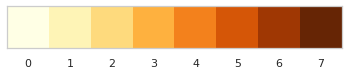

<Figure size 576x432 with 0 Axes>

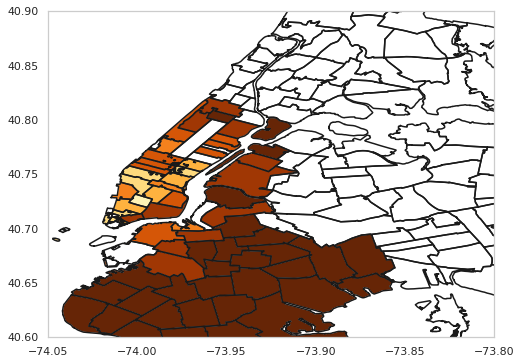

In [275]:
color_ton, _ = calc_color(list(zip_left['perc']), ref_bins=bins)

ax = plot_map_fill(idx_left, sf, color_ton, x_lim=[-74.05, -73.8], y_lim=[40.6, 40.9], figsize=(8,6))

In [149]:
"""import geopandas as gpd

tmp = gpd.GeoDataFrame.from_file('./data/shapefiles/ZIP_CODE_040114.shp')

tmpWGS84 = tmp.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

tmpWGS84.to_file('./data/shapefiles_/ZIP_CODE_040114.shp')"""

"import geopandas as gpd\n\ntmp = gpd.GeoDataFrame.from_file('./data/shapefiles/ZIP_CODE_040114.shp')\n\ntmpWGS84 = tmp.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})\n\ntmpWGS84.to_file('./data/shapefiles_/ZIP_CODE_040114.shp')"